In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import *
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.efficientnet import EfficientNetB4

import numpy as np
from sklearn.utils import shuffle

import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import cv2

import os

In [3]:
IMAGE_SIZE = 256

def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = np.mean(image, axis=-1)/255.0
        images.append(image)
    return np.array(images)

In [4]:
def datagen(train_img, mask_img, batch_size):
    for x in range(0, len(train_img), batch_size=16):
        images = open_images(train_img[x:x+batch_size]).reshape(-1,IMAGE_SIZE, IMAGE_SIZE, 3)
        masks = open_images(mask_img[x:x+batch_size]).reshape(-1,IMAGE_SIZE, IMAGE_SIZE, 3)
        yield images, masks

In [5]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [6]:
image_path1='/content/gdrive/MyDrive/data/from_hot/1/'
image_path2='/content/gdrive/MyDrive/data/from_hot/2/'
image_path3='/content/gdrive/MyDrive/data/from_hot/3/'
image_path4='/content/gdrive/MyDrive/data/from_hot/4/'
image_path5='/content/gdrive/MyDrive/data/from_hot/5/'
all_image_paths = [[image_path1+file for file in os.listdir(image_path1)]+[image_path2+file for file in os.listdir(image_path2)]+[image_path3+file for file in os.listdir(image_path3)]+[image_path4+file for file in os.listdir(image_path4)]+[image_path5+file for file in os.listdir(image_path5)]][0]

In [7]:
label_path1='/content/gdrive/MyDrive/data/rasterized_labels/1/'
label_path2='/content/gdrive/MyDrive/data/rasterized_labels/2/'
label_path3='/content/gdrive/MyDrive/data/rasterized_labels/3/'
label_path4='/content/gdrive/MyDrive/data/rasterized_labels/4/'
label_path5='/content/gdrive/MyDrive/data/rasterized_labels/5/'

all_masks_paths=[[label_path1+file for file in os.listdir(label_path1)]+[label_path2+file for file in os.listdir(label_path2)]+[label_path3+file for file in os.listdir(label_path3)]+[label_path4+file for file in os.listdir(label_path4)]+[label_path5+file for file in os.listdir(label_path5)]][0]

In [8]:
all_image_paths=sorted(all_image_paths)
all_masks_paths=sorted(all_masks_paths)

In [9]:
all_images_paths=[]
for images in all_image_paths:
  if(images.endswith('.png')):
    all_images_paths.append(images)

In [10]:
all_images=open_images(all_images_paths)
all_masks=open_images(all_masks_paths)

In [11]:
import albumentations as A
import cv2

transform = A.Compose([
    A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=0.5),
])

In [12]:
transformed_images=[]
transformed_masks=[]
i=0
for i in range (len(all_images)):
  image=all_images[i]
  mask=all_masks[i]
  transformed = transform(image=image, mask=mask)
  transformed_images.append(transformed['image'])
  transformed_masks.append(transformed['mask'])

In [13]:
all_images=list(all_images)
for image in transformed_images:
  all_images.append(image)
len(all_images)
all_masks=list(all_masks)
for mask in transformed_masks:
  all_masks.append(mask)
len(all_masks)

324

In [14]:
all_images=np.array(all_images)
all_masks=np.array(all_masks)

In [15]:
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [17]:
model=tf.keras.models.load_model('/content/gdrive/MyDrive/open_cities_model.h5',compile=False)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef,'accuracy',iou_coef])

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_images.reshape(-1,IMAGE_SIZE, IMAGE_SIZE, 1), all_masks.reshape(-1,IMAGE_SIZE, IMAGE_SIZE, 1), test_size = 0.25, random_state = 0)

In [19]:
history=model.fit(X_train,y_train,validation_data=[X_test,y_test], batch_size=16, epochs=50)

Epoch 1/50
16/16 [==============================] - 14s 182ms/step - loss: 0.3102 - dice_coef: 0.3591 - accuracy: 0.8643 - iou_coef: 0.1717 - val_loss: 0.2473 - val_dice_coef: 0.3051 - val_accuracy: 0.8923 - val_iou_coef: 0.1416
Epoch 2/50
16/16 [==============================] - 1s 79ms/step - loss: 0.2603 - dice_coef: 0.4285 - accuracy: 0.8772 - iou_coef: 0.2104 - val_loss: 0.2279 - val_dice_coef: 0.3479 - val_accuracy: 0.8971 - val_iou_coef: 0.1650
Epoch 3/50
16/16 [==============================] - 1s 80ms/step - loss: 0.2272 - dice_coef: 0.4807 - accuracy: 0.8951 - iou_coef: 0.2569 - val_loss: 0.2036 - val_dice_coef: 0.4179 - val_accuracy: 0.9027 - val_iou_coef: 0.2091
Epoch 4/50
16/16 [==============================] - 1s 79ms/step - loss: 0.2072 - dice_coef: 0.5326 - accuracy: 0.9067 - iou_coef: 0.2860 - val_loss: 0.1947 - val_dice_coef: 0.4316 - val_accuracy: 0.9096 - val_iou_coef: 0.2148
Epoch 5/50
16/16 [==============================] - 1s 80ms/step - loss: 0.1838 - dice_coe

In [20]:
k=model.predict(X_test)

3/3 [==============================] - 2s 297ms/step


In [21]:
i2=X_test
j2=y_test

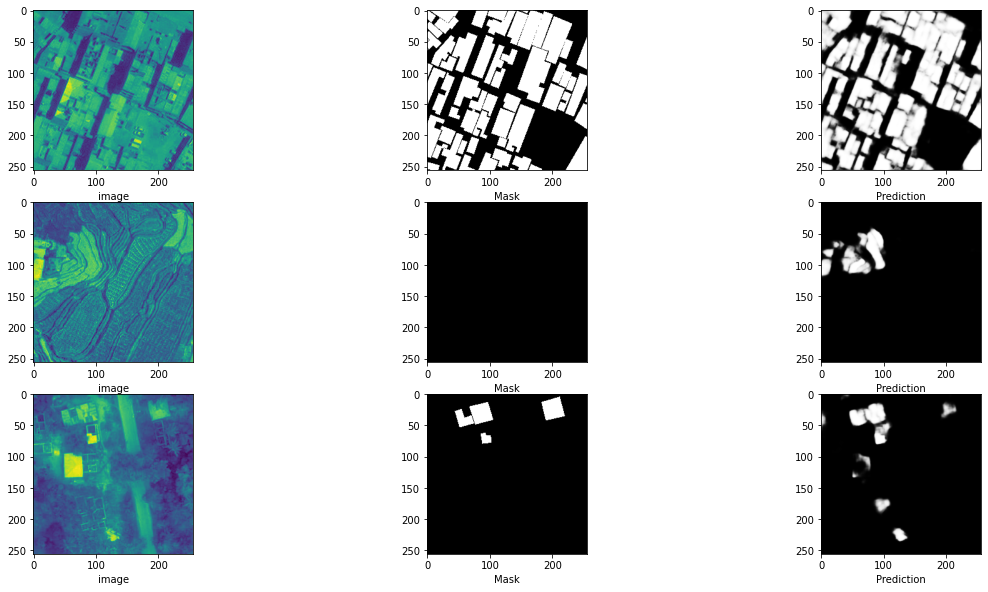

In [22]:
plt.figure(figsize=(20,10))
for x in range(0,9,3):
    plt.subplot(3,3,x+1)
    
    plt.xlabel("image")
    plt.imshow(np.squeeze(i2[x+5]))
     
    
    plt.subplot(3,3,x+2)
    plt.xlabel("Mask")
    plt.imshow(np.squeeze(j2[x+5]),cmap='gray')
        
    plt.subplot(3,3,x+3)
    plt.xlabel("Prediction")
    plt.imshow(np.squeeze(k[x+5]),cmap='gray')